In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'


from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
import core

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [2]:
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [3]:
df_theta = df[(df.table_id == 'Omon') & (df.variable_id == 'thetao')]
uri = df_theta[(df_theta.source_id == 'SAM0-UNICON') &
                         (df_theta.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_theta = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
df_v = df[(df.table_id == 'Omon') & (df.variable_id == 'vo')]
uri = df_v[(df_v.source_id == 'SAM0-UNICON') &
                         (df_v.experiment_id == 'historical')].zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')
ds_v = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#run_counts = df_v.groupby(['source_id', 'experiment_id'])['zstore'].count()
#run_counts

In [4]:
def finegrid_metrics(levs,lev_bnds):
    drF=np.diff(lev_bnds,axis=1)
    drC=np.concatenate((np.array([levs[0]]),np.diff(levs,axis=0),np.array([lev_bnds[-1,-1]-levs[-1]])))
    return(drF,drC)

In [5]:
fine_drf,fine_drc=finegrid_metrics(ds_theta.lev.values,ds_theta.lev_bnds.values)
fine_drc.size

61

In [6]:
import finegrid
print(finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,10]))#np.squeeze(fine_drf).T,

(array([0.16666667, 0.16666667, 0.16666667, ..., 4.1662083 , 4.1662083 ,
       4.1662083 ], dtype=float32), array([ 1,  1,  1, ..., 59, 59, 59], dtype=int32), array([1., 1., 1., ..., 0., 0., 0.], dtype=float32), array([ 1,  1,  1, ..., 60, 60, 60], dtype=int32))


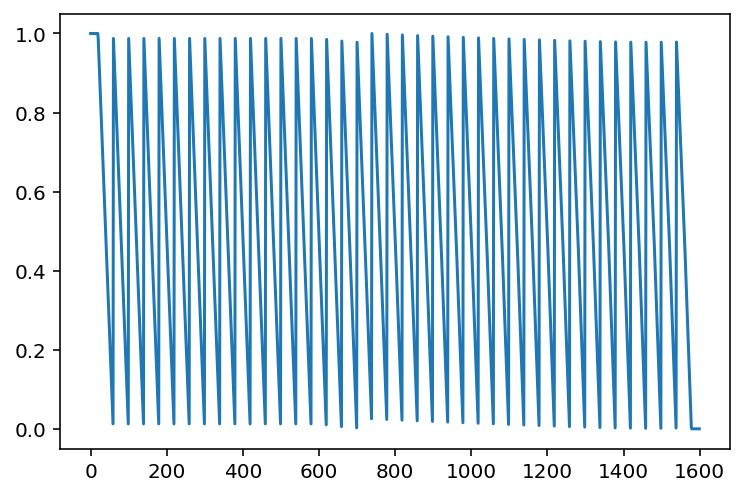

In [7]:
drf_finer,mapindex,mapfact,cellindex=finegrid.finegrid(np.squeeze(fine_drf[0:40]),np.squeeze(fine_drc[0:41]),[fine_drf[0:40].size,10])
plt.plot(mapfact)

In [8]:
import layers
thetalayers=np.linspace(4,21,80)
VH=layers.layers_1(ds_v.vo[0,0:40,100,100].values,
         ds_theta.thetao[0,0:40,100,100].values,thetalayers,mapfact,mapindex,cellindex,drf_finer)

In [9]:
VH.sum()

6.698477

In [10]:
v_in=ds_v.vo[0:10,0:40,100,100]#.squeeze()#.transpose('lev','time')
theta_in=ds_theta.thetao[0:10,0:40,100,100]#.squeeze()#.transpose('lev','time')
#original_shape = v_in.shape

#v_out,theta_out=core._reshape_inputs(v_in,theta_in)

In [11]:
#dimension order is (outside loop, inside loop)
#import layers
thetalayers=np.linspace(4,21,80)
#VH2=layers.loop_layers(v_out,
#         theta_out,thetalayers,mapfact,mapindex,cellindex,drf_finer)
#VH2.size

In [30]:
#new_shape=list(original_shape)
#new_shape[0]=thetalayers.size
#new_shape=tuple(new_shape)
#v_lay=np.squeeze(np.array(core._reshape_outputs(VH2, shape=new_shape)))

In [31]:
#v_lay=core.layers_numpy(v_in,theta_in,thetalayers,mapfact,mapindex,cellindex,drf_finer)

In [59]:
def v_map(v_in,theta_in, thetalayers,mapfact,mapindex,cellindex,drf_finer):
    import dask.array as da
    v_lay=da.map_blocks(core.layers_numpy, v_in,theta_in, thetalayers,mapfact,mapindex,cellindex,drf_finer)
    return v_lay
v_lay=v_map(v_in,theta_in, thetalayers,mapfact,mapindex,cellindex,drf_finer).compute()

In [83]:
v_lay1=xr.apply_ufunc(core.layers_numpy,v_in, theta_in.chunk({'time': 2}),
                      kwargs={'thetalayers':thetalayers,'mapfact':mapfact,
                                                  'mapindex':mapindex,'cellindex':cellindex,
                                                  'drf_finer':drf_finer},
                     dask='parallelized',input_core_dims=[['lev'],['lev']],output_core_dims=[['Tlev']],
                     output_dtypes=[float],output_sizes={'Tlev':thetalayers.size})


In [84]:
v_lay1

<xarray.DataArray (time: 10, Tlev: 80)>
dask.array<layers_numpy, shape=(10, 80), dtype=float64, chunksize=(2, 80), chunktype=numpy.ndarray>
Coordinates:
    i        int32 100
    j        int32 100
  * time     (time) object 1850-01-17 00:30:00 ... 1850-10-16 12:00:00
Dimensions without coordinates: Tlev

In [85]:
v_lay1.data

dask.array<layers_numpy, shape=(10, 80), dtype=float64, chunksize=(2, 80), chunktype=numpy.ndarray>

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.614754 to fit


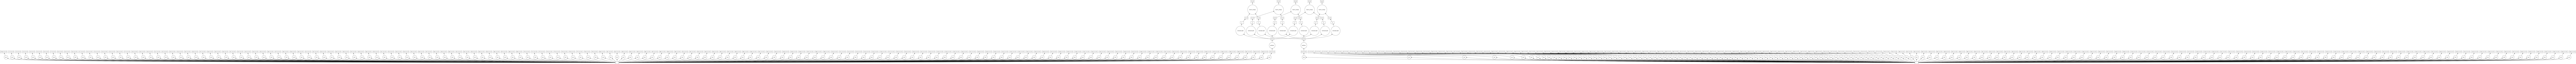

In [86]:
v_lay1.data.visualize()

In [70]:
v_lay1.compute()

<xarray.DataArray (time: 10, Tlev: 80)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.98296323e-01,  5.66560887e-02,
         5.36946617e-02,  7.60998428e-02,  7.60998428e-02,
         5.91887645e-02,  5.91887645e-02,  6.01641126e-02,
         8.04889128e-02,  7.15456977e-02,  7.15456977e-02,
         6.26024827e-02,  7.12783560e-02,  7.92858750e-02,
         7.92858750e-02,  7.92858750e-02,  7.92858750e-02,
         8.41839686e-02,  8.32060948e-02,  9.15267020e-02,
         9.15267020e-02,  1.00037217e-01,  1.00037217e-01,
         1.00037217e-01,  1.13826945e-01,  1.13207221e-01,
         1.15891010e-01,  1.17476873e-01,  1.15614645e-01,
         1.21218719e-01,  1.08310945e-01,  1.13359705e-01,
         9.63557512e-02,  1.01642132e-01,  9.59741473e-02,
         9.18828174e-02,  9.07138810e-02,  8.81390497e-02,
         8.60791802e-02,  8.47074687e-02,  8.65175799e-02,
         7.70036504e-02,  8.26528221e-02,  7.83026740e-02,
         7.94018

In [28]:
v_check=core.layers_numpy(v_in,theta_in, thetalayers,mapfact,mapindex,cellindex,drf_finer)
np.sum(v_check[0,:])

6.698477

In [61]:
core.layers_numpy( v_in,theta_in, thetalayers,mapfact,mapindex,cellindex,drf_finer)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.98296323e-01,  5.66560887e-02,
         5.36946617e-02,  7.60998428e-02,  7.60998428e-02,
         5.91887645e-02,  5.91887645e-02,  6.01641126e-02,
         8.04889128e-02,  7.15456977e-02,  7.15456977e-02,
         6.26024827e-02,  7.12783560e-02,  7.92858750e-02,
         7.92858750e-02,  7.92858750e-02,  7.92858750e-02,
         8.41839686e-02,  8.32060948e-02,  9.15267020e-02,
         9.15267020e-02,  1.00037217e-01,  1.00037217e-01,
         1.00037217e-01,  1.13826945e-01,  1.13207221e-01,
         1.15891010e-01,  1.17476873e-01,  1.15614645e-01,
         1.21218719e-01,  1.08310945e-01,  1.13359705e-01,
         9.63557512e-02,  1.01642132e-01,  9.59741473e-02,
         9.18828174e-02,  9.07138810e-02,  8.81390497e-02,
         8.60791802e-02,  8.47074687e-02,  8.65175799e-02,
         7.70036504e-02,  8.26528221e-02,  7.83026740e-02,
         7.94018283e-02,  7.92212188e-02,  7.66728967e-0

In [62]:
v_np = _
v_np.shape

(10, 80)

In [41]:
v_in

<xarray.DataArray 'vo' (time: 10, lev: 40)>
dask.array<getitem, shape=(10, 40), dtype=float32, chunksize=(10, 40), chunktype=numpy.ndarray>
Coordinates:
    i          int32 100
    j          int32 100
    latitude   float64 dask.array<chunksize=(), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 35.0 45.0 ... 707.6 787.0 878.8 984.7
    longitude  float64 dask.array<chunksize=(), meta=np.ndarray>
  * time       (time) object 1850-01-17 00:30:00 ... 1850-10-16 12:00:00
Attributes:
    cell_methods:    time: mean (interval: 1 month)
    comment:         Prognostic y-ward velocity component resolved by the model.
    long_name:       Sea Water Y Velocity
    original_units:  centimeter/s
    standard_name:   sea_water_y_velocity
    units:           m s-1